# 🏠 Entraînement Modèle Location - Compatible avec app.py

Ce notebook génère **EXACTEMENT** les fichiers attendus par `app.py` :

## 📦 Fichiers générés :
1. `model_Location_final_stacking.pkl` - Le modèle ML
2. `location_target_encoder.pkl` - Encodeur pour catégories
3. `location_scaler.pkl` - Scaler pour normalisation
4. `location_feature_names.pkl` - Noms des features
5. `location_model_performance_summary.csv` - Performances

## ✅ Feature Engineering identique à app.py :
```python
new_data['surface_rooms'] = surface_m2 * num_rooms
new_data['bathrooms_rooms_ratio'] = num_bathrooms / (num_rooms + 1)
new_data['total_rooms'] = num_rooms + num_bathrooms
new_data['surface_per_room'] = surface_m2 / (total_rooms + 1)
new_data['price_per_m2'] = 80  # Pour location
```

## 1️⃣ Imports et Configuration

In [1]:
import numpy as np
import pandas as pd
import pickle
import os
from pathlib import Path
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# ML
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, StackingRegressor
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
from category_encoders import TargetEncoder

# Graphiques
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', 60)
plt.style.use('seaborn-v0_8-darkgrid')

print("✅ Imports réussis")

✅ Imports réussis


## 2️⃣ Configuration des Chemins

In [2]:
# Chemins des données et modèles
DATA_PATH = Path("..") / "data" / "clean_data" / "location_all_sources.csv"
MODEL_DIR = Path("..") / "models"
MODEL_DIR.mkdir(exist_ok=True)

# Paramètres
RANDOM_STATE = 42
TEST_SIZE = 0.2
USE_STACKING = True  # True pour meilleure précision, False pour rapidité

print(f"📂 Données : {DATA_PATH}")
print(f"📦 Modèles seront sauvés dans : {MODEL_DIR}")
print(f"🎯 Stacking Ensemble : {'Activé' if USE_STACKING else 'Désactivé'}")

📂 Données : ..\data\clean_data\location_all_sources.csv
📦 Modèles seront sauvés dans : ..\models
🎯 Stacking Ensemble : Activé


## 3️⃣ Chargement des Données

In [3]:
# Charger les données
assert DATA_PATH.exists(), f"❌ Fichier introuvable : {DATA_PATH}"

df = pd.read_csv(DATA_PATH, encoding='utf-8-sig')

print(f"✅ Données chargées : {len(df):,} lignes")
print(f"📊 Colonnes : {list(df.columns)}")
print(f"\n📈 Shape : {df.shape}")
df.head()

✅ Données chargées : 15,856 lignes
📊 Colonnes : ['ville', 'prix', 'surface', 'quartier', 'type_bien', 'nb_chambres', 'nb_salle_de_bain', 'url_annonce', 'source']

📈 Shape : (15856, 9)


,ville,prix,surface,quartier,type_bien,nb_chambres,nb_salle_de_bain,url_annonce,source
0,Casablanca,20000.0,48.0,Maarif,Appartement,5,1,https://www.avito.ma/fr/maarif/appartements/__...,Avito
1,Tanger,6500.0,90.0,Castilla,Appartement,4,1,https://www.avito.ma/fr/castilla/appartements/...,Avito
2,Casablanca,17000.0,155.0,Racine,Appartement,3,1,https://www.avito.ma/fr/racine/appartements/CM...,Avito
3,Casablanca,2300.0,56.0,Oulfa,Appartement,3,1,https://www.avito.ma/fr/oulfa/appartements/App...,Avito
4,Casablanca,5500.0,90.0,Route d'Azemmour,Appartement,3,1,https://www.avito.ma/fr/route_d_azemmour/appar...,Avito


## 4️⃣ Renommage et Préparation

In [4]:
# Renommer EXACTEMENT comme dans app.py
df = df.rename(columns={
    'ville': 'city',
    'prix': 'price',
    'surface': 'surface_m2',
    'nb_chambres': 'num_rooms',
    'nb_salle_de_bain': 'num_bathrooms',
    'type_bien': 'property_type'
})

print("✅ Colonnes renommées")
print(f"📊 Colonnes actuelles : {list(df.columns)}")

# Info avant nettoyage
print(f"\n📊 AVANT nettoyage :")
print(f"   - Lignes : {len(df):,}")
print(f"   - Prix moyen : {df['price'].mean():,.0f} DH")
print(f"   - Surface moyenne : {df['surface_m2'].mean():.1f} m²")

✅ Colonnes renommées
📊 Colonnes actuelles : ['city', 'price', 'surface_m2', 'quartier', 'property_type', 'num_rooms', 'num_bathrooms', 'url_annonce', 'source']

📊 AVANT nettoyage :
   - Lignes : 15,856
   - Prix moyen : 10,083 DH
   - Surface moyenne : 125.4 m²


## 5️⃣ Nettoyage des Données

In [5]:
initial_count = len(df)

# 1. Supprimer les NaN critiques
df = df.dropna(subset=['price', 'surface_m2', 'city'])
print(f"1️⃣ Suppression NaN : {initial_count - len(df):,} lignes")

# 2. Valeurs positives
df = df[(df['price'] > 0) & (df['surface_m2'] > 0)]
print(f"2️⃣ Valeurs > 0 : {initial_count - len(df):,} lignes supprimées")

# 3. Filtres métier (règles business)
df = df[df['price'] >= 500]       # Loyer minimum
df = df[df['price'] <= 50000]     # Loyer maximum
df = df[df['surface_m2'] >= 10]   # Surface minimum
df = df[df['surface_m2'] <= 1000] # Surface maximum

# 4. Filtrer outliers extrêmes avec IQR
def remove_outliers_iqr(data, column, factor=2.5):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - factor * IQR
    upper = Q3 + factor * IQR
    before = len(data)
    data = data[(data[column] >= lower) & (data[column] <= upper)]
    print(f"   - {column}: {before - len(data):,} outliers (< {lower:.0f} ou > {upper:.0f})")
    return data

print("3️⃣ Suppression outliers IQR :")
df = remove_outliers_iqr(df, 'price', factor=2.5)
df = remove_outliers_iqr(df, 'surface_m2', factor=2.5)

# 5. Remplir NaN pour chambres/salles de bain
df['num_rooms'] = df['num_rooms'].fillna(df['num_rooms'].median())
df['num_bathrooms'] = df['num_bathrooms'].fillna(df['num_bathrooms'].median())

print(f"\n✅ APRÈS nettoyage : {len(df):,} lignes ({initial_count - len(df):,} supprimées)")
print(f"   - Prix : min={df['price'].min():.0f}, max={df['price'].max():.0f}, mean={df['price'].mean():.0f}")
print(f"   - Surface : min={df['surface_m2'].min():.0f}, max={df['surface_m2'].max():.0f}, mean={df['surface_m2'].mean():.0f}")

1️⃣ Suppression NaN : 0 lignes
2️⃣ Valeurs > 0 : 0 lignes supprimées
3️⃣ Suppression outliers IQR :
   - price: 693 outliers (< -12850 ou > 29750)
   - surface_m2: 589 outliers (< -78 ou > 252)

✅ APRÈS nettoyage : 14,458 lignes (1,398 supprimées)
   - Prix : min=500, max=29700, mean=8006
   - Surface : min=10, max=250, mean=90


## 6️⃣ Feature Engineering (IDENTIQUE à app.py)

In [6]:
# Features EXACTEMENT comme dans app.py
print("🔧 Feature Engineering...")

df['surface_rooms'] = df['surface_m2'] * df['num_rooms']
df['bathrooms_rooms_ratio'] = df['num_bathrooms'] / (df['num_rooms'] + 1)
df['total_rooms'] = df['num_rooms'] + df['num_bathrooms']
df['surface_per_room'] = df['surface_m2'] / (df['total_rooms'] + 1)
df['price_per_m2'] = 80  # Constante pour location (comme dans app.py)

print("✅ Features créées :")
print("   - surface_rooms")
print("   - bathrooms_rooms_ratio")
print("   - total_rooms")
print("   - surface_per_room")
print("   - price_per_m2")

🔧 Feature Engineering...
✅ Features créées :
   - surface_rooms
   - bathrooms_rooms_ratio
   - total_rooms
   - surface_per_room
   - price_per_m2


## 7️⃣ Définition des Features

In [7]:
# Features EXACTEMENT comme app.py les attend
numeric_features = [
    'surface_m2',
    'num_rooms',
    'num_bathrooms',
    'surface_rooms',
    'bathrooms_rooms_ratio',
    'total_rooms',
    'surface_per_room',
    'price_per_m2'
]

categorical_features = [
    'city',
    'quartier',
    'property_type'
]

all_features = numeric_features + categorical_features

print(f"📊 Features numériques ({len(numeric_features)}) :")
for f in numeric_features:
    print(f"   - {f}")

print(f"\n📊 Features catégorielles ({len(categorical_features)}) :")
for f in categorical_features:
    print(f"   - {f}")

print(f"\n✅ Total : {len(all_features)} features")

📊 Features numériques (8) :
   - surface_m2
   - num_rooms
   - num_bathrooms
   - surface_rooms
   - bathrooms_rooms_ratio
   - total_rooms
   - surface_per_room
   - price_per_m2

📊 Features catégorielles (3) :
   - city
   - quartier
   - property_type

✅ Total : 11 features


## 8️⃣ Préparation X et y

In [8]:
# Préparer les données
X = df[all_features].copy()
y = df['price'].copy()

print(f"✅ X shape : {X.shape}")
print(f"✅ y shape : {y.shape}")
print(f"\n📊 Statistiques de y (prix) :")
print(y.describe())

✅ X shape : (14458, 11)
✅ y shape : (14458,)

📊 Statistiques de y (prix) :
count    14458.000000
mean      8005.918763
std       4847.967166
min        500.000000
25%       4500.000000
50%       7000.000000
75%      10000.000000
max      29700.000000
Name: price, dtype: float64


## 9️⃣ Train-Test Split

In [9]:
# Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
    shuffle=True
)

print(f"🔀 Split réalisé :")
print(f"   - Train : {len(X_train):,} lignes ({len(X_train)/len(X)*100:.1f}%)")
print(f"   - Test  : {len(X_test):,} lignes ({len(X_test)/len(X)*100:.1f}%)")

🔀 Split réalisé :
   - Train : 11,566 lignes (80.0%)
   - Test  : 2,892 lignes (20.0%)


## 🔟 Target Encoding

In [10]:
# Target Encoder (EXACTEMENT comme app.py l'utilise)
print("🎯 Target Encoding...")

encoder = TargetEncoder(
    cols=categorical_features,
    smoothing=10.0,
    min_samples_leaf=20
)

# Copier les données
X_train_encoded = X_train.copy()
X_test_encoded = X_test.copy()

# Encoder
X_train_encoded[categorical_features] = encoder.fit_transform(
    X_train[categorical_features],
    y_train
)

X_test_encoded[categorical_features] = encoder.transform(
    X_test[categorical_features]
)

print("✅ Encoding terminé")
print(f"\n📊 Exemple d'encodage (première ligne train) :")
print(X_train_encoded[categorical_features].head(1))

🎯 Target Encoding...


✅ Encoding terminé

📊 Exemple d'encodage (première ligne train) :
             city     quartier  property_type
8322  7415.206077  6741.465082     8034.78393


## 1️⃣1️⃣ Standardisation

In [11]:
# Scaler (EXACTEMENT comme app.py l'utilise)
print("📏 Standardisation...")

scaler = StandardScaler()

# Copier les données encodées
X_train_scaled = X_train_encoded.copy()
X_test_scaled = X_test_encoded.copy()

# Scaler
X_train_scaled[numeric_features] = scaler.fit_transform(
    X_train_encoded[numeric_features]
)

X_test_scaled[numeric_features] = scaler.transform(
    X_test_encoded[numeric_features]
)

print("✅ Standardisation terminée")
print(f"\n📊 Exemple après scaling (première ligne train) :")
print(X_train_scaled[numeric_features].head(1))

📏 Standardisation...
✅ Standardisation terminée

📊 Exemple après scaling (première ligne train) :
      surface_m2  num_rooms  num_bathrooms  surface_rooms  \
8322   -0.836858  -0.770054      -0.350679      -0.762532   

      bathrooms_rooms_ratio  total_rooms  surface_per_room  price_per_m2  
8322               0.021702    -0.834295         -0.658235           0.0  


## 1️⃣2️⃣ Entraînement des Modèles

In [12]:
print("="*80)
print("🏋️ ENTRAÎNEMENT DES MODÈLES")
print("="*80)

# Modèle 1 : Gradient Boosting
print("\n1️⃣ Gradient Boosting...")
gb_model = GradientBoostingRegressor(
    n_estimators=300,
    max_depth=5,
    learning_rate=0.05,
    min_samples_split=10,
    min_samples_leaf=5,
    subsample=0.9,
    random_state=RANDOM_STATE,
    verbose=0
)

gb_model.fit(X_train_scaled, y_train)
print("✅ Gradient Boosting entraîné")

# Prédictions GB
y_pred_gb_train = gb_model.predict(X_train_scaled)
y_pred_gb_test = gb_model.predict(X_test_scaled)

# Métriques GB
r2_gb = r2_score(y_test, y_pred_gb_test)
rmse_gb = np.sqrt(mean_squared_error(y_test, y_pred_gb_test))
mae_gb = mean_absolute_error(y_test, y_pred_gb_test)

print(f"   - R² : {r2_gb:.4f}")
print(f"   - RMSE : {rmse_gb:,.0f} DH")
print(f"   - MAE : {mae_gb:,.0f} DH")

🏋️ ENTRAÎNEMENT DES MODÈLES

1️⃣ Gradient Boosting...
✅ Gradient Boosting entraîné
   - R² : 0.7044
   - RMSE : 2,684 DH
   - MAE : 1,840 DH


In [13]:
# Modèle 2 : Stacking Ensemble (optionnel)
if USE_STACKING:
    print("\n2️⃣ Stacking Ensemble...")
    
    # Modèles de base
    base_models = [
        ('gb', GradientBoostingRegressor(
            n_estimators=200,
            max_depth=4,
            learning_rate=0.05,
            random_state=RANDOM_STATE
        )),
        ('rf', RandomForestRegressor(
            n_estimators=200,
            max_depth=10,
            min_samples_split=10,
            random_state=RANDOM_STATE,
            n_jobs=-1
        ))
    ]
    
    # Meta-modèle
    meta_model = Ridge(alpha=10.0)
    
    # Stacking
    stacking_model = StackingRegressor(
        estimators=base_models,
        final_estimator=meta_model,
        cv=3,
        n_jobs=-1
    )
    
    stacking_model.fit(X_train_scaled, y_train)
    print("✅ Stacking Ensemble entraîné")
    
    # Prédictions Stacking
    y_pred_stack_test = stacking_model.predict(X_test_scaled)
    
    # Métriques Stacking
    r2_stack = r2_score(y_test, y_pred_stack_test)
    rmse_stack = np.sqrt(mean_squared_error(y_test, y_pred_stack_test))
    mae_stack = mean_absolute_error(y_test, y_pred_stack_test)
    
    print(f"   - R² : {r2_stack:.4f}")
    print(f"   - RMSE : {rmse_stack:,.0f} DH")
    print(f"   - MAE : {mae_stack:,.0f} DH")
    
    # Choisir le meilleur
    if rmse_stack < rmse_gb:
        print(f"\n🏆 Stacking gagne ! (RMSE: {rmse_stack:.0f} vs {rmse_gb:.0f})")
        final_model = stacking_model
        model_name = "StackingEnsemble"
        r2_final = r2_stack
        rmse_final = rmse_stack
        mae_final = mae_stack
        y_pred_final = y_pred_stack_test
    else:
        print(f"\n🏆 Gradient Boosting gagne ! (RMSE: {rmse_gb:.0f} vs {rmse_stack:.0f})")
        final_model = gb_model
        model_name = "GradientBoosting"
        r2_final = r2_gb
        rmse_final = rmse_gb
        mae_final = mae_gb
        y_pred_final = y_pred_gb_test
else:
    print("\n⚡ Stacking désactivé, on garde Gradient Boosting")
    final_model = gb_model
    model_name = "GradientBoosting"
    r2_final = r2_gb
    rmse_final = rmse_gb
    mae_final = mae_gb
    y_pred_final = y_pred_gb_test


2️⃣ Stacking Ensemble...
✅ Stacking Ensemble entraîné
   - R² : 0.7072
   - RMSE : 2,672 DH
   - MAE : 1,828 DH

🏆 Stacking gagne ! (RMSE: 2672 vs 2684)


## 1️⃣3️⃣ Évaluation Complète

In [14]:
print("\n" + "="*80)
print("📊 ÉVALUATION DU MODÈLE FINAL")
print("="*80)

# Prédictions train
y_pred_train = final_model.predict(X_train_scaled)

# Métriques Train
r2_train = r2_score(y_train, y_pred_train)
rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
mae_train = mean_absolute_error(y_train, y_pred_train)
mape_train = mean_absolute_percentage_error(y_train, y_pred_train) * 100

# Métriques Test
mape_test = mean_absolute_percentage_error(y_test, y_pred_final) * 100

print(f"\n🎯 Modèle : {model_name}")
print("\n📈 TRAIN SET:")
print(f"   - R² Score : {r2_train:.4f}")
print(f"   - RMSE     : {rmse_train:,.0f} DH")
print(f"   - MAE      : {mae_train:,.0f} DH")
print(f"   - MAPE     : {mape_train:.2f}%")

print("\n📉 TEST SET:")
print(f"   - R² Score : {r2_final:.4f}")
print(f"   - RMSE     : {rmse_final:,.0f} DH")
print(f"   - MAE      : {mae_final:,.0f} DH")
print(f"   - MAPE     : {mape_test:.2f}%")

# Vérifier overfitting
overfit = r2_train - r2_final
if overfit > 0.1:
    print(f"\n⚠️ Overfitting détecté : {overfit:.4f}")
else:
    print(f"\n✅ Pas d'overfitting : {overfit:.4f}")

# Cross-validation
print("\n🔄 Cross-Validation (5-fold)...")
cv_scores = cross_val_score(
    final_model, X_train_scaled, y_train,
    cv=5, scoring='r2', n_jobs=-1
)
print(f"   - CV R² moyen : {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")


📊 ÉVALUATION DU MODÈLE FINAL

🎯 Modèle : StackingEnsemble

📈 TRAIN SET:
   - R² Score : 0.7875
   - RMSE     : 2,224 DH
   - MAE      : 1,552 DH
   - MAPE     : 28.38%

📉 TEST SET:
   - R² Score : 0.7072
   - RMSE     : 2,672 DH
   - MAE      : 1,828 DH
   - MAPE     : 34.75%

✅ Pas d'overfitting : 0.0803

🔄 Cross-Validation (5-fold)...
   - CV R² moyen : 0.7086 (+/- 0.0129)


## 1️⃣4️⃣ Analyse des Erreurs

In [15]:
print("\n" + "="*80)
print("🔍 ANALYSE DES ERREURS")
print("="*80)

errors = y_test - y_pred_final
abs_errors = np.abs(errors)
percent_errors = abs_errors / y_test * 100

print(f"\n📊 Distribution des erreurs :")
print(f"   - Erreur moyenne      : {errors.mean():,.0f} DH")
print(f"   - Erreur absolue moy. : {abs_errors.mean():,.0f} DH")
print(f"   - Erreur médiane      : {np.median(errors):,.0f} DH")
print(f"   - Erreur max          : {abs_errors.max():,.0f} DH")
print(f"   - % erreur < 10%      : {(percent_errors < 10).sum() / len(percent_errors) * 100:.1f}%")
print(f"   - % erreur < 20%      : {(percent_errors < 20).sum() / len(percent_errors) * 100:.1f}%")

# Pires prédictions
worst_idx = abs_errors.nlargest(5).index
print("\n⚠️ Top 5 pires prédictions :")
for i, idx in enumerate(worst_idx, 1):
    actual = y_test.loc[idx]
    predicted = y_pred_final[list(y_test.index).index(idx)]
    error = abs_errors.loc[idx]
    print(f"   {i}. Réel: {actual:,.0f} DH, Prédit: {predicted:,.0f} DH, Erreur: {error:,.0f} DH")


🔍 ANALYSE DES ERREURS

📊 Distribution des erreurs :
   - Erreur moyenne      : 5 DH
   - Erreur absolue moy. : 1,828 DH
   - Erreur médiane      : -83 DH
   - Erreur max          : 16,409 DH
   - % erreur < 10%      : 29.6%
   - % erreur < 20%      : 56.1%

⚠️ Top 5 pires prédictions :
   1. Réel: 950 DH, Prédit: 17,359 DH, Erreur: 16,409 DH
   2. Réel: 7,000 DH, Prédit: 23,066 DH, Erreur: 16,066 DH
   3. Réel: 29,700 DH, Prédit: 13,725 DH, Erreur: 15,975 DH
   4. Réel: 25,000 DH, Prédit: 9,465 DH, Erreur: 15,535 DH
   5. Réel: 25,000 DH, Prédit: 11,662 DH, Erreur: 13,338 DH


## 1️⃣5️⃣ Visualisations

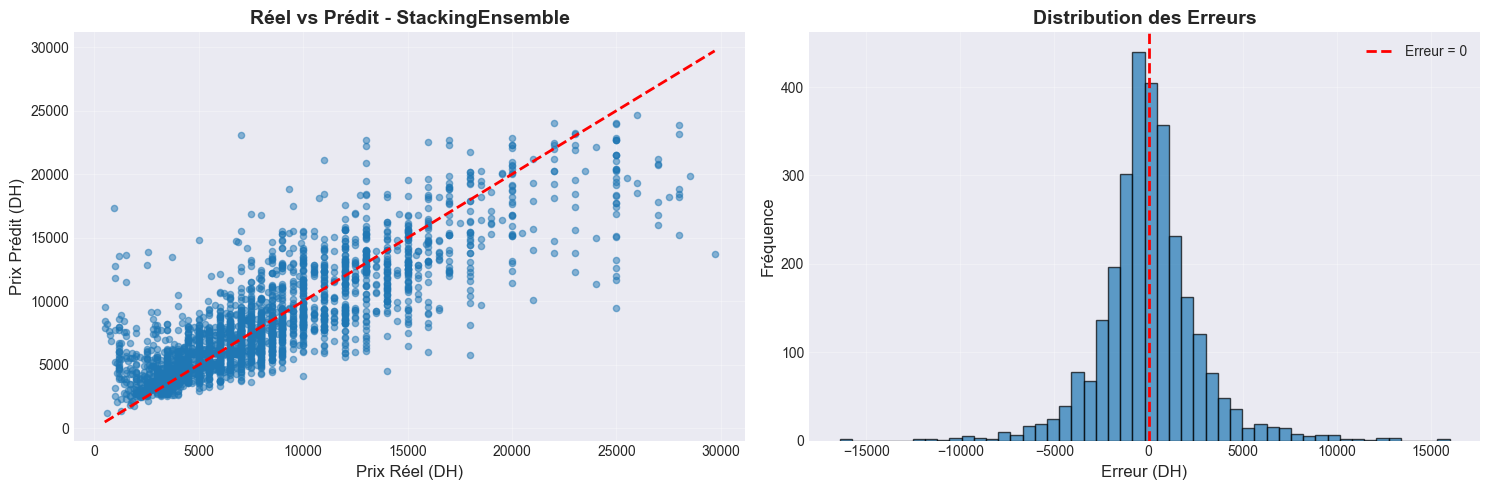

✅ Graphiques affichés


In [16]:
# Graphique 1 : Réel vs Prédit
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot 1 : Scatter
axes[0].scatter(y_test, y_pred_final, alpha=0.5, s=20)
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[0].set_xlabel('Prix Réel (DH)', fontsize=12)
axes[0].set_ylabel('Prix Prédit (DH)', fontsize=12)
axes[0].set_title(f'Réel vs Prédit - {model_name}', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# Plot 2 : Distribution des erreurs
axes[1].hist(errors, bins=50, edgecolor='black', alpha=0.7)
axes[1].axvline(0, color='red', linestyle='--', linewidth=2, label='Erreur = 0')
axes[1].set_xlabel('Erreur (DH)', fontsize=12)
axes[1].set_ylabel('Fréquence', fontsize=12)
axes[1].set_title('Distribution des Erreurs', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("✅ Graphiques affichés")

In [17]:
# Graphique 2 : Feature Importances (si disponible)
if hasattr(final_model, 'feature_importances_'):
    importances = final_model.feature_importances_
    feature_importance_df = pd.DataFrame({
        'feature': all_features,
        'importance': importances
    }).sort_values('importance', ascending=False)
    
    plt.figure(figsize=(12, 6))
    plt.barh(feature_importance_df['feature'][:15], feature_importance_df['importance'][:15])
    plt.xlabel('Importance', fontsize=12)
    plt.ylabel('Feature', fontsize=12)
    plt.title('Top 15 Features les Plus Importantes', fontsize=14, fontweight='bold')
    plt.gca().invert_yaxis()
    plt.grid(True, alpha=0.3, axis='x')
    plt.tight_layout()
    plt.show()
    
    print("\n🔝 Top 10 features :")
    for i, row in feature_importance_df.head(10).iterrows():
        print(f"   {row['feature']:30s} : {row['importance']:.4f}")
else:
    print("⚠️ Feature importances non disponibles pour ce modèle")

⚠️ Feature importances non disponibles pour ce modèle


## 1️⃣6️⃣ SAUVEGARDE (Compatible app.py)

In [18]:
print("\n" + "="*80)
print("💾 SAUVEGARDE DES FICHIERS POUR APP.PY")
print("="*80)

# 1. Sauvegarder le modèle
model_path = MODEL_DIR / 'model_Location_final_stacking.pkl'
with open(model_path, 'wb') as f:
    pickle.dump(final_model, f)
print(f"✅ 1/4 - {model_path.name}")

# 2. Sauvegarder le target encoder
encoder_path = MODEL_DIR / 'location_target_encoder.pkl'
with open(encoder_path, 'wb') as f:
    pickle.dump(encoder, f)
print(f"✅ 2/4 - {encoder_path.name}")

# 3. Sauvegarder le scaler
scaler_path = MODEL_DIR / 'location_scaler.pkl'
with open(scaler_path, 'wb') as f:
    pickle.dump(scaler, f)
print(f"✅ 3/4 - {scaler_path.name}")

# 4. Sauvegarder les noms de features
features_path = MODEL_DIR / 'location_feature_names.pkl'
with open(features_path, 'wb') as f:
    pickle.dump({
        'numeric_features': numeric_features,
        'categorical_features': categorical_features
    }, f)
print(f"✅ 4/4 - {features_path.name}")

# 5. Sauvegarder les performances
perf_df = pd.DataFrame([{
    'model_name': model_name,
    'r2_train': r2_train,
    'r2_test': r2_final,
    'rmse_train_dh': rmse_train,
    'rmse_test_dh': rmse_final,
    'mae_train_dh': mae_train,
    'mae_test_dh': mae_final,
    'mape_train': mape_train,
    'mape_test': mape_test,
    'cv_r2_mean': cv_scores.mean(),
    'cv_r2_std': cv_scores.std(),
    'n_train': len(X_train),
    'n_test': len(X_test),
    'n_features': len(all_features),
    'date_training': datetime.now().strftime('%Y-%m-%d %H:%M:%S')
}])

perf_path = MODEL_DIR / 'location_model_performance_summary.csv'
perf_df.to_csv(perf_path, index=False)
print(f"✅ 5/5 - {perf_path.name}")

print(f"\n📦 Tous les fichiers sont dans : {MODEL_DIR.absolute()}")


💾 SAUVEGARDE DES FICHIERS POUR APP.PY
✅ 1/4 - model_Location_final_stacking.pkl
✅ 2/4 - location_target_encoder.pkl
✅ 3/4 - location_scaler.pkl
✅ 4/4 - location_feature_names.pkl
✅ 5/5 - location_model_performance_summary.csv

📦 Tous les fichiers sont dans : c:\Users\Z01X\Desktop\analyse-des-tendances-immobili-res-\notebooks\..\models


## 1️⃣7️⃣ Test de Compatibilité avec app.py

In [19]:
print("\n" + "="*80)
print("🧪 TEST DE COMPATIBILITÉ AVEC APP.PY")
print("="*80)

# Simuler exactement ce que fait app.py
print("\nSimulation d'une requête comme dans app.py...\n")

# 1. Charger les fichiers (comme app.py)
with open(MODEL_DIR / 'model_Location_final_stacking.pkl', 'rb') as f:
    model_loaded = pickle.load(f)

with open(MODEL_DIR / 'location_target_encoder.pkl', 'rb') as f:
    encoder_loaded = pickle.load(f)

with open(MODEL_DIR / 'location_scaler.pkl', 'rb') as f:
    scaler_loaded = pickle.load(f)

with open(MODEL_DIR / 'location_feature_names.pkl', 'rb') as f:
    features_loaded = pickle.load(f)

print("✅ Tous les fichiers chargés avec succès\n")

# 2. Créer des données de test (comme une requête utilisateur)
test_input = {
    'city': 'Casablanca',
    'quartier': 'Maârif',
    'property_type': 'Appartement',
    'surface_m2': 120,
    'num_rooms': 3,
    'num_bathrooms': 2
}

print("📥 Données de test :")
for key, val in test_input.items():
    print(f"   - {key}: {val}")

# 3. Feature Engineering (EXACTEMENT comme app.py)
new_data = pd.DataFrame([test_input])
new_data['surface_rooms'] = new_data['surface_m2'] * new_data['num_rooms']
new_data['bathrooms_rooms_ratio'] = new_data['num_bathrooms'] / (new_data['num_rooms'] + 1)
new_data['total_rooms'] = new_data['num_rooms'] + new_data['num_bathrooms']
new_data['surface_per_room'] = new_data['surface_m2'] / (new_data['total_rooms'] + 1)
new_data['price_per_m2'] = 80

# 4. Récupérer les features
num_feat = features_loaded['numeric_features']
cat_feat = features_loaded['categorical_features']
all_feat = num_feat + cat_feat

# 5. Préparer les features
new_features = new_data[all_feat].copy()

# 6. Target Encoding
new_features[cat_feat] = encoder_loaded.transform(new_features[cat_feat])

# 7. Standardisation
new_features[num_feat] = scaler_loaded.transform(new_features[num_feat])

# 8. Prédiction
prediction = float(model_loaded.predict(new_features)[0])

print(f"\n💰 Prédiction : {prediction:,.2f} DH/mois")
print(f"📊 Prix/m² : {prediction/test_input['surface_m2']:,.2f} DH")

print("\n✅ TEST RÉUSSI ! Le modèle est compatible avec app.py")


🧪 TEST DE COMPATIBILITÉ AVEC APP.PY

Simulation d'une requête comme dans app.py...

✅ Tous les fichiers chargés avec succès

📥 Données de test :
   - city: Casablanca
   - quartier: Maârif
   - property_type: Appartement
   - surface_m2: 120
   - num_rooms: 3
   - num_bathrooms: 2

💰 Prédiction : 11,969.33 DH/mois
📊 Prix/m² : 99.74 DH

✅ TEST RÉUSSI ! Le modèle est compatible avec app.py


## 1️⃣8️⃣ Résumé Final

In [20]:
print("\n" + "="*80)
print("✅ ENTRAÎNEMENT TERMINÉ AVEC SUCCÈS !")
print("="*80)

print(f"\n🎯 Modèle final : {model_name}")
print(f"\n📊 Performances TEST :")
print(f"   - R² Score    : {r2_final:.4f} ({r2_final*100:.1f}% de variance expliquée)")
print(f"   - RMSE        : {rmse_final:,.0f} DH")
print(f"   - MAE         : {mae_final:,.0f} DH")
print(f"   - MAPE        : {mape_test:.2f}%")
print(f"   - CV R² moyen : {cv_scores.mean():.4f}")

print(f"\n📦 Fichiers sauvegardés :")
print(f"   ✓ model_Location_final_stacking.pkl")
print(f"   ✓ location_target_encoder.pkl")
print(f"   ✓ location_scaler.pkl")
print(f"   ✓ location_feature_names.pkl")
print(f"   ✓ location_model_performance_summary.csv")

print(f"\n📁 Localisation : {MODEL_DIR.absolute()}")

print("\n🚀 Le modèle est prêt à être utilisé dans app.py !")
print("   Pour lancer l'API : python app.py")
print("="*80)


✅ ENTRAÎNEMENT TERMINÉ AVEC SUCCÈS !

🎯 Modèle final : StackingEnsemble

📊 Performances TEST :
   - R² Score    : 0.7072 (70.7% de variance expliquée)
   - RMSE        : 2,672 DH
   - MAE         : 1,828 DH
   - MAPE        : 34.75%
   - CV R² moyen : 0.7086

📦 Fichiers sauvegardés :
   ✓ model_Location_final_stacking.pkl
   ✓ location_target_encoder.pkl
   ✓ location_scaler.pkl
   ✓ location_feature_names.pkl
   ✓ location_model_performance_summary.csv

📁 Localisation : c:\Users\Z01X\Desktop\analyse-des-tendances-immobili-res-\notebooks\..\models

🚀 Le modèle est prêt à être utilisé dans app.py !
   Pour lancer l'API : python app.py
